This notebook examine how difference evalaution methods affect the conclusion

In [6]:
import pandas as pd 
import json 
import copy
import re 
from collections import Counter, defaultdict
from matplotlib import pyplot as plt

pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',500)
import seaborn as sns 
sns.set_theme(style="white")
sns.color_palette("husl", 8)

# path = 'cache/bert-large-uncased/lm_diagnostic_extended/sgpl/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv'
# df = pd.read_csv(path)



[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)]

In [4]:
def concept_evaluation(label, pred):
    '''
    
    label: a list with the singualr and plural labels (e.g., ['tool', 'tools'])
    pred: the top K prediction list 

    return:
        1 if label share with pred else 0  
    '''
    if not isinstance(label, list):
        label = eval(label)
        
    if not isinstance(pred, list):
        pred = eval(pred)

    shared = set(label).intersection(set(pred))
    return 1 if len(shared)>0 else 0 
    

def get_precision_at_k_concept(df, relation, pred_cols, label_col, k_list, pred_col_suffix='obj_mask_'):

    p_at_x = [] #defaultdict() 
    for pred_col in pred_cols: 
        suffix = pred_col.replace(pred_col_suffix, "")
        prec_cur = defaultdict()
        prec_cur['mask_type'] = suffix
        for k in k_list: 
            df[f'p{k}_{suffix}'] = df[[label_col, pred_col]].apply(lambda x: concept_evaluation(x[0], eval(x[1])[:k]), axis=1 )
            prec_cur[f'p@{k}'] = round(df[f'p{k}_{suffix}'].mean() , 3)*100

        p_at_x.append(prec_cur)  

    # aggregate the average precision across k 
    df_res = pd.DataFrame(p_at_x) #, columns=['mask_type', 'mAP'])
    df_res['relation'] = [relation]*len(df_res)
    return df_res

pred_cols = ['obj_mask_def_sap', 'obj_mask_def_dap', 'obj_mask_lsp_sap', 'obj_mask_lsp_dap']
pred_col_suffix = 'obj_mask_'
# label_cols = ['obj_label_singular', 'obj_label_plural']
label_col = 'obj_label'
k=1 

df_prec = get_precision_at_k_concept(df, relation, pred_cols, label_col, k_list=[1,5])

# print(df['p1_def_sap_new'].mean())
# print(df['p5_def_sap_new'].mean())
# print(len(df.index))
# df[['sub_label', 'obj_label', 'obj_mask_def_sap', 'p1_def_sap_new', 'p5_def_sap_new']].head(5)

NameError: name 'df' is not defined

In [39]:
vocab_single = ["flower", "tool", "building", "insect", "vegetable", "tree", "vehicle", "bird", "fish"]
vocab_plural = ["trees", "flowers", "tools", "vegetables", "insects", "birds", "vehicles", "fish", "buildings"]

df['obj_label_singular'] = df['obj_label'].apply(lambda x: [eval(x)[0]])
df['obj_label_plural'] = df['obj_label'].apply(lambda x: [eval(x)[-1]])

df[['obj_label_singular', 'obj_label_plural']]


pred_cols = ['obj_mask_def_sap', 'obj_mask_def_dap', 'obj_mask_lsp_sap', 'obj_mask_lsp_dap']
pred_col_suffix = 'obj_mask_'
label_cols = ['obj_label_singular', 'obj_label_plural']

k=1 
p_at_x = [] #defaultdict() 
relation = "IsA"

# def eval_singular_plural(method='or', label_singular, label_plural, pred):
#     if method = 'or':
#         return 1 if x[0][0] in eval(x[1])[:k] else 0, axis=1 
    

for pred_col in pred_cols: 
    
    suffix = pred_col.replace(pred_col_suffix, "") 
    for label_col in label_cols: 
        prec_cur = defaultdict()
        print(label_col) 
        df[f'p{k}_{suffix}'] = df[['obj_label_singular', 'obj_label_plural', pred_col]].apply(lambda x: 1 if x[0][0] in eval(x[2])[:k] or x[1][0] in  eval(x[2])[:k]  else 0, axis=1 )
#         df[f'p{k}_{suffix}'] = df[['obj_label_singular', 'obj_label_plural', pred_col]].apply(lambda x: 1 if x[0][0] in eval(x[2])[:k] and x[1][0] in  eval(x[2])[:k]  else 0, axis=1 )
        prec_cur[f'p@{k}'] = round(df[f'p{k}_{suffix}'].mean() , 3)*100
        prec_cur['mask_type'] = suffix 
        prec_cur['obj'] = label_col  
        p_at_x.append(prec_cur)
        
df_res = pd.DataFrame(p_at_x) #,  columns=['mask_type', 'mAP', 'obj'])
df_res['relation'] = [relation]*len(df_res)
for name, group in df_res.groupby(by=['mask_type']):
    display(group)

obj_label_singular
obj_label_plural
obj_label_singular
obj_label_plural
obj_label_singular
obj_label_plural
obj_label_singular
obj_label_plural


,p@1,mask_type,obj,relation
2,17.5,def_dap,obj_label_singular,IsA
3,17.5,def_dap,obj_label_plural,IsA


,p@1,mask_type,obj,relation
0,13.5,def_sap,obj_label_singular,IsA
1,13.5,def_sap,obj_label_plural,IsA


,p@1,mask_type,obj,relation
6,33.3,lsp_dap,obj_label_singular,IsA
7,33.3,lsp_dap,obj_label_plural,IsA


,p@1,mask_type,obj,relation
4,20.5,lsp_sap,obj_label_singular,IsA
5,20.5,lsp_sap,obj_label_plural,IsA


# 221129 

In [13]:
# import pandas as pd 
# import json 
# import copy
# import re 
# from collections import Counter, defaultdict
# from matplotlib import pyplot as plt

# pd.set_option('display.max_columns',100)
# pd.set_option('display.max_colwidth',500)

# path = '../results_analysis.xlsx'
# df = pd.read_excel(path, sheet_name = 'ConceptEvaluation')
# df.head()

# vis_mask_types = ['def_sap', 'lsp_sap', 'def_dap', 'lsp_dap']
# vis_datasets = ['lm_diagnostic_extended', 'clsb']
# df = df.query(f"mask_type in {vis_mask_types}")
# df =df.query(f"dataset in {vis_datasets}")
# # df.index = df.dataset
# # df.plot(kind='bar')

# df = df.sort_values(by='mask_type')
# for metric in ['p@1', 'p@5', 'mrr']: 
    
#     df_pivot = pd.pivot_table(
#         df,
#         values=metric,
#         index="dataset",
#         columns="mask_type",
#     # 	aggfunc=np.mean
#     )

#     # Plot a bar chart using the DF
#     ax = df_pivot.plot(kind="bar")
#     # Get a Matplotlib figure from the axes object for formatting purposes
#     fig = ax.get_figure()
#     # Change the plot dimensions (width, height)
#     fig.set_size_inches(7, 6)
#     # Change the axes labels
#     ax.set_xlabel("Datasets")
#     ax.set_ylabel(metric)
#     plt.legend(loc=(1,0.3))
#     plt.title(metric)
#     # Use this to show the plot in a new window
#     plt.show()
#     # Export the plot as a PNG file
#     fig.savefig("page_views_barplot.png")

# 221201 


## How does target filtering help?

## How does the anchor filtering affect the performance?

NameError: name 'figure_prefix' is not defined

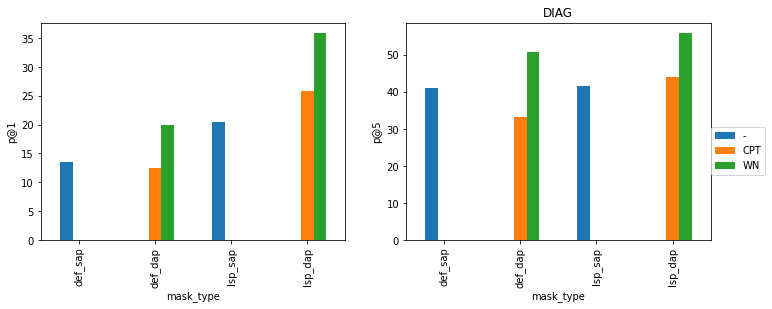

In [6]:
path = '../results_analysis.xlsx'

df_all  = pd.read_excel(path, sheet_name='ConceptEvaluation')
mask_types = ['def_sap', 'def_dap', 'lsp_sap', 'lsp_dap']
mapping = {type: i for i, type in enumerate(mask_types)}
key = df_all['mask_type'].map(mapping)

# wo OBJ filter + CP 
df_all = df_all.query("filter_obj == False") #filter_anchors=='WN'")

for dataset in ['DIAG', 'clsb', 'bless', 'eval', 'leds']: 
    df = df_all.query(f"dataset =='{dataset}'")
    # fig_dir = '../cache/figures/'
    # figure_prefix  = fig_dir + 'wo_filter_obj_cpt'

#     display(df)
    #################################

    query_mask_type_groups =[['def_sap','def_dap', 'lsp_sap', 'lsp_dap']]
    for query_mask_type in query_mask_type_groups:
        df = df.query(f"mask_type in {query_mask_type}")

        fig, (ax1, ax2) = plt.subplots(1,2, sharey=False)
        fig.set_size_inches(12, 4)

        metrics = ['p@1', 'p@5'] #, 'mrr']
        for metric, ax in zip(metrics, (ax1, ax2)): # , ax3)):
            df_pivot = pd.pivot_table(
                df,
                values= metric,
                index= 'mask_type', # ["filter_anchors"], #, "filter_obj"], "dataset", 
                columns=  'filter_anchors', #["mask_type"], #'filter_obj'],
                sort = False,
                # 	aggfunc=np.mean
            )
            # Plot a bar chart using the DF
            ax = df_pivot.plot(kind="bar", ax=ax)
            ax.set_ylabel(metric)
            ax.get_legend().remove()
    #         ax.set_title(metric)
            
        # Use this to show the plot in a new window
        plt.title(f"{dataset}")
        plt.legend( loc=(1,0.3))
        figure_path = figure_prefix + "-".join(query_mask_type) + '.pdf'
        plt.savefig(figure_path)
        plt.show()
        plt.clf()



## How does the choices of prompt affects the performance

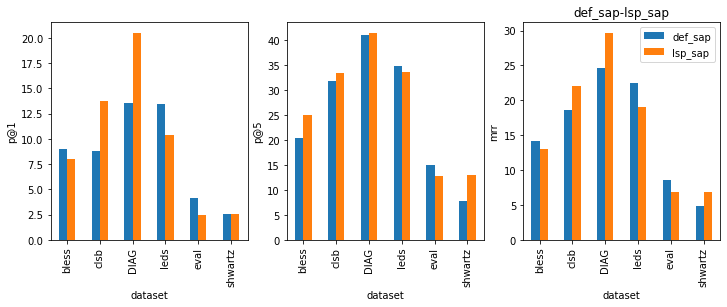

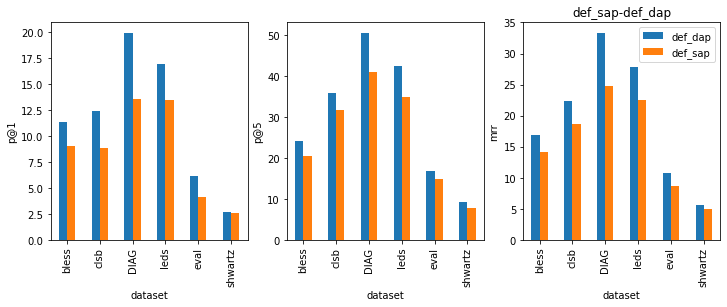

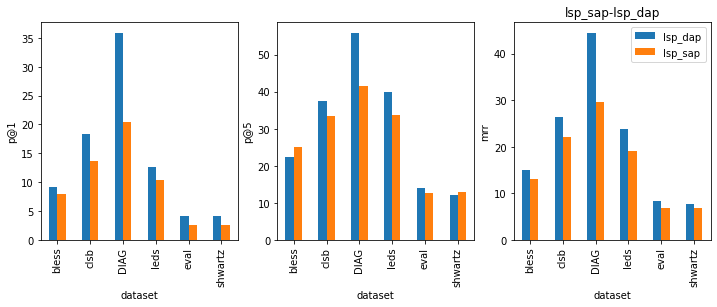

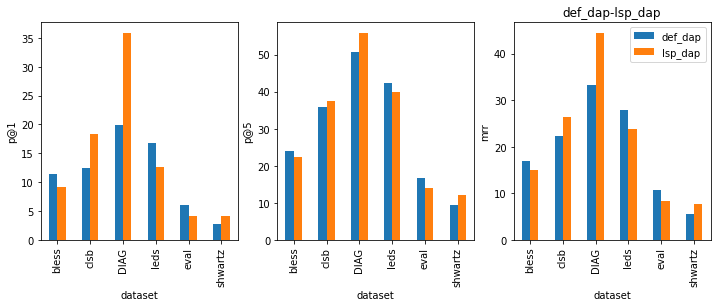

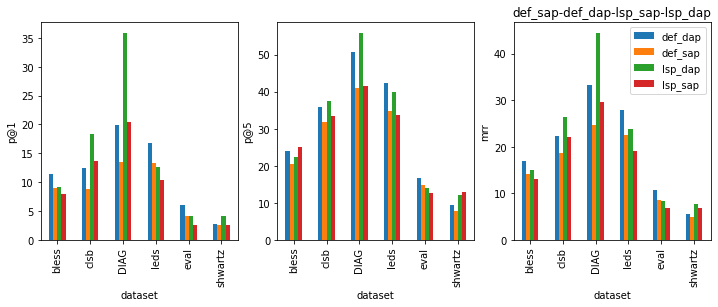

In [9]:
path = '../results_analysis.xlsx'

df_all  = pd.read_excel(path, sheet_name='ConceptEvaluation')
# df_all = df_all.query("filter_obj==False")
# wo OBJ filter + CP 
# df_all = df_all.query("filter_obj==False and filter_anchors!='WN'")
# fig_dir = '../cache/figures/'
# figure_prefix  = fig_dir + 'wo_filter_obj_cpt'

# W OBJ filter + CP
# df_all = df_all.query("filter_obj==True and filter_anchors!='WN'")
# fig_dir = '../cache/figures/'
# figure_prefix  = fig_dir + 'w_filter_obj_cpt'

# W OBJ filter + WN
# df_all = df_all.query("filter_obj==False and filter_anchors!='CPT'")
df_all = df_all.query("filter_anchors!='CPT'")
fig_dir = '../cache/figures/'
figure_prefix  = fig_dir + 'w_filter_obj_wn'



#################################

mask_types = ['def_sap', 'def_dap', 'lsp_sap', 'lsp_dap']
mapping = {type: i for i, type in enumerate(mask_types)}
key = df_all['mask_type'].map(mapping)

# df = df.iloc[key.argsort()]
query_mask_type_groups =[  ['def_sap', 'lsp_sap'], ['def_sap', 'def_dap'], ['lsp_sap', 'lsp_dap'], ['def_dap', 'lsp_dap'], ['def_sap','def_dap', 'lsp_sap', 'lsp_dap']]
for query_mask_type in query_mask_type_groups:
    df = df_all.query(f"mask_type in {query_mask_type}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)
    fig.set_size_inches(12, 4)

    metrics = ['p@1', 'p@5', 'mrr']
    for metric, ax in zip(metrics, (ax1, ax2, ax3)):
        df_pivot = pd.pivot_table(
            df,
            values= metric,
            index="dataset",
            columns= "mask_type",
            sort = False,
            # 	aggfunc=np.mean
        )
        # Plot a bar chart using the DF
        ax = df_pivot.plot(kind="bar", ax=ax)
        ax.set_ylabel(metric)
        ax.get_legend().remove()
#         ax.set_title(metric)
    # Use this to show the plot in a new window
    plt.title(f"{'-'.join(query_mask_type)}")
    plt.legend(loc='best') #loc=(1,0.3))
    figure_path = figure_prefix + "-".join(query_mask_type) + '.pdf'
#     plt.savefig(figure_path)
    plt.show()


    # Get a Matplotlib figure from the axes object for formatting purposes
#     fig = ax.get_figure()
    # Change the plot dimensions (width, height)
    #     fig.set_size_inches(7, 6)
    # Change the axes labels
    # ax.set_xlabel("Datasets")


## Final results

## Which anchor filter function work best?

- WN works best 
- CPT and RAW are similar 

We choose to use the RAW version, considerring that (i) it's fast than CPT (ii) we explore the knowledge encoded in the LMs without relying on external knowledge.

In [1]:
!scp spartan:~/cogsci/DAP/log/221207_all_results.csv ../log

/home/chunhua/.bashrc: line 103: bind: warning: line editing not enabled
/home/chunhua/.bashrc: line 104: bind: warning: line editing not enabled
221207_all_results.csv                        100% 4596   434.1KB/s   00:00    


In [24]:
path  = '../log/221207_all_results.csv'
df_all = pd.read_csv(path)
df_all = df_all.loc[:, ~df_all.columns.str.contains('^Unnamed*')]
df_all = df_all.query("filter_anchors!='CPT'")
query_cols = ['mask_type', 'p@1', 'p@5', 'mAP@1', 'mAP@5', 'mAP@10', 'anchor_wordnet_avg_path', 'anchor_wordnet_coverage', 'filter_anchors', 'dataset']
df_all = df_all.query("dataset == 'lm_diagnostic_extended-singular'")
df_all[query_cols]


,mask_type,p@1,p@5,mAP@1,mAP@5,mAP@10,anchor_wordnet_avg_path,anchor_wordnet_coverage,filter_anchors,dataset
4,def_sap,13.4,8.2,13.4,23.2,24.5,10.19,0.870,RAW,lm_diagnostic_extended-singular
5,lsp_sap,27.3,9.1,27.3,34.1,35.3,10.19,0.870,RAW,lm_diagnostic_extended-singular
6,def_dap,16.0,8.1,16.0,25.6,27.4,10.19,0.870,RAW,lm_diagnostic_extended-singular
7,lsp_dap,26.0,8.4,26.0,32.0,33.1,10.19,0.870,RAW,lm_diagnostic_extended-singular
24,def_sap,12.8,8.0,12.8,22.4,23.9,6.94,0.992,WN,lm_diagnostic_extended-singular
25,lsp_sap,27.3,9.0,27.3,34.0,35.3,6.94,0.992,WN,lm_diagnostic_extended-singular
26,def_dap,23.1,10.7,23.1,34.8,36.3,6.94,0.992,WN,lm_diagnostic_extended-singular
27,lsp_dap,39.1,10.8,39.1,44.7,45.7,6.94,0.992,WN,lm_diagnostic_extended-singular


filter_anchors,RAW,WN
dataset,,
hypernymsuite-BLESS,66.750,64.500
lm_diagnostic_extended-singular,20.675,25.575
clsb-singular,46.050,45.650
hypernymsuite-LEDS,15.850,15.950
hypernymsuite-EVAL,8.025,7.600
hypernymsuite-SHWARTZ,3.525,3.350


filter_anchors,RAW,WN
dataset,,
hypernymsuite-BLESS,72.400,71.250
lm_diagnostic_extended-singular,28.725,33.975
clsb-singular,53.150,52.825
hypernymsuite-LEDS,24.250,24.225
hypernymsuite-EVAL,15.875,15.000
hypernymsuite-SHWARTZ,6.700,6.525


filter_anchors,RAW,WN
dataset,,
hypernymsuite-BLESS,64.775,63.200
lm_diagnostic_extended-singular,30.075,35.300
clsb-singular,51.250,51.075
hypernymsuite-LEDS,25.350,25.525
hypernymsuite-EVAL,17.075,16.325
hypernymsuite-SHWARTZ,7.475,7.325


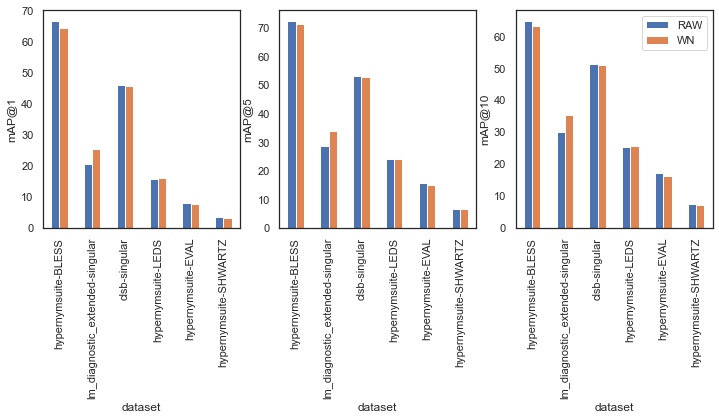

In [26]:
path  = '../log/221207_all_results.csv'
df_all = pd.read_csv(path)
df_all = df_all.loc[:, ~df_all.columns.str.contains('^Unnamed*')]
df_all = df_all.query("filter_anchors!='CPT'")
query_cols = ['mask_type', 'p@1', 'p@5', 'mAP@1', 'mAP@5', 'mAP@10', 'anchor_wordnet_avg_path', 'anchor_wordnet_coverage', 'filter_anchors']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)
fig.set_size_inches(12, 4)
metrics = ['mAP@1', 'mAP@5', 'mAP@10']
for metric, ax in zip(metrics, (ax1, ax2, ax3)):
    df_pivot = pd.pivot_table(
        df_all,
        values= metric,
        index="dataset",
        columns= 'filter_anchors', #"mask_type",
        sort = False,
        # 	aggfunc=np.mean
    )
    # Plot a bar chart using the DF
    ax = df_pivot.plot(kind="bar", ax=ax)
    ax.set_ylabel(metric)
    ax.get_legend().remove()
    display(df_pivot)
#         ax.set_title(metric)
# Use this to show the plot in a new window
# plt.title(f"{'-'.join(query_mask_type)}")
plt.legend(loc='best') #loc=(1,0.3))
# figure_path = figure_prefix + "-".join(query_mask_type) + '.pdf'
#     plt.savefig(figure_path)
plt.show()


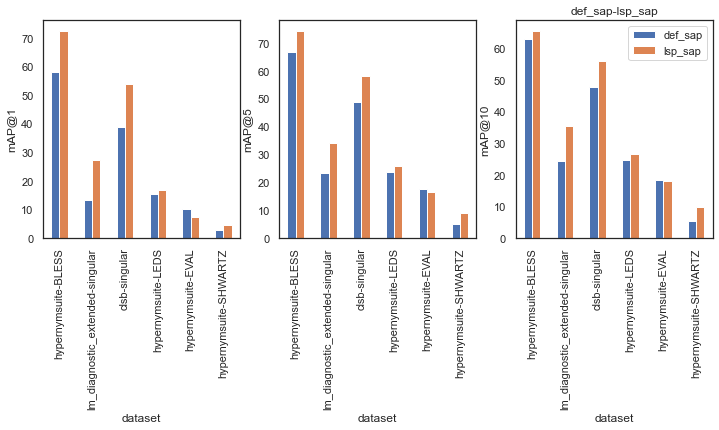

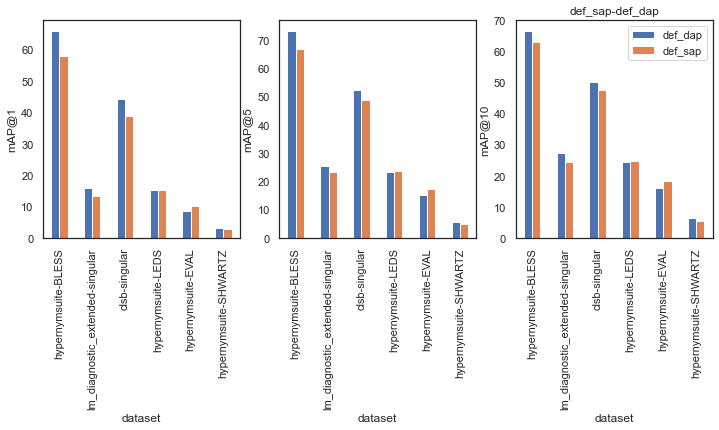

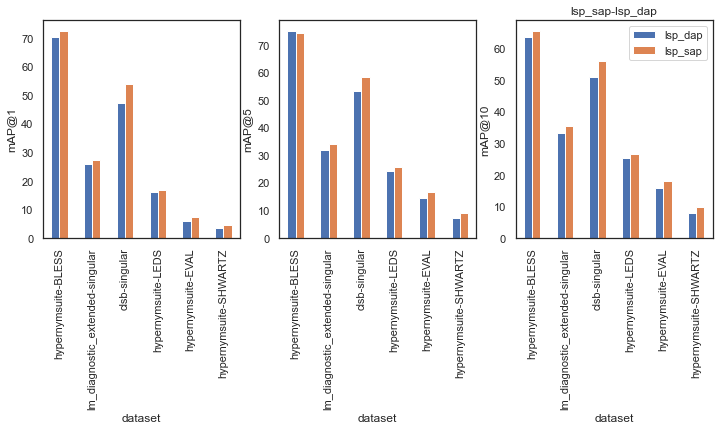

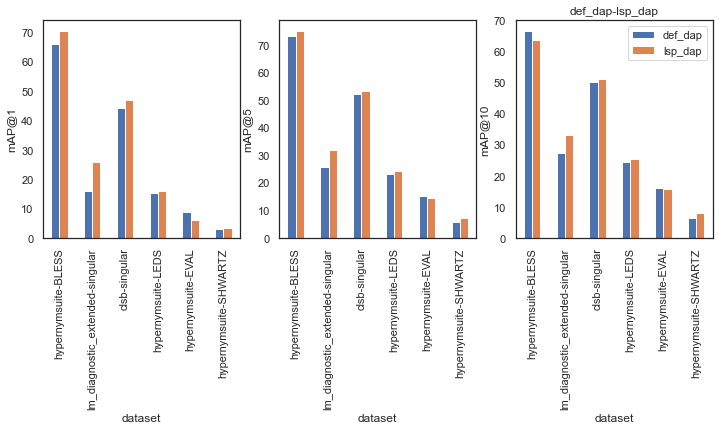

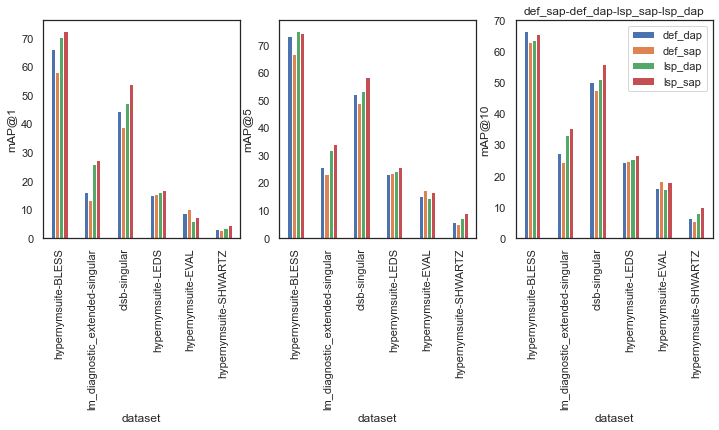

In [22]:

path  = '../log/221207_all_results.csv'
df_all = pd.read_csv(path)
df_all = df_all.loc[:, ~df_all.columns.str.contains('^Unnamed*')]

df_all = df_all.query("filter_anchors=='RAW'")
fig_dir = '../cache/figures/'
figure_prefix  = fig_dir + 'w_filter_obj_wn'

#################################

mask_types = ['def_sap', 'def_dap', 'lsp_sap', 'lsp_dap']
mapping = {type: i for i, type in enumerate(mask_types)}
key = df_all['mask_type'].map(mapping)

# df = df.iloc[key.argsort()]
query_mask_type_groups =[  ['def_sap', 'lsp_sap'], ['def_sap', 'def_dap'], ['lsp_sap', 'lsp_dap'], ['def_dap', 'lsp_dap'], ['def_sap','def_dap', 'lsp_sap', 'lsp_dap']]
for query_mask_type in query_mask_type_groups:
    df = df_all.query(f"mask_type in {query_mask_type}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)
    fig.set_size_inches(12, 4)
    
#     metrics = ['p@1', 'p@5', 'mrr']
    metrics = ['mAP@1', 'mAP@5', 'mAP@10']
    for metric, ax in zip(metrics, (ax1, ax2, ax3)):
        df_pivot = pd.pivot_table(
            df,
            values= metric,
            index="dataset",
            columns= "mask_type",
            sort = False,
            # 	aggfunc=np.mean
        )
        # Plot a bar chart using the DF
        ax = df_pivot.plot(kind="bar", ax=ax)
        ax.set_ylabel(metric)
        ax.get_legend().remove()
#         ax.set_title(metric)
    # Use this to show the plot in a new window
    plt.title(f"{'-'.join(query_mask_type)}")
    plt.legend(loc='best') #loc=(1,0.3))
    figure_path = figure_prefix + "-".join(query_mask_type) + '.pdf'
#     plt.savefig(figure_path)
    plt.show()


# Format results into tables in paper

In [27]:
datasets_to_shorter={'clsb-singular': 'CLSB',
 'hypernymsuite-BLESS': 'BLESS',
 'hypernymsuite-EVAL': 'EVAL',
 'hypernymsuite-LEDS': 'LEDS',
 'hypernymsuite-SHWARTZ': 'SHWARTZ',
 'lm_diagnostic_extended-singular': 'LMDIAG'}

path  = '../log/221207_all_results.csv'
df_all = pd.read_csv(path)
df_all = df_all.loc[:, ~df_all.columns.str.contains('^Unnamed*')]

df_all = df_all.query("filter_anchors == 'WN'")
df_all['dataset'] = df_all['dataset'].apply(lambda x: datasets_to_shorter.get(x)) 
df_all = df_all.rename(columns={'mask_type': 'pattern_type'})

# 'mAP@10', 'filter_anchors',   'anchor_wordnet_avg_path', 'anchor_wordnet_coverage',
query_cols = ['pattern_type', 'dataset',  'mAP@1', 'mAP@5', ]

# df_all = pd.MultiIndex.from_frame(df_all, names=['pattern_type', 'dataset'])

# df_pivot = pd.pivot_table(
#         df_all,
#         values= ['mAP@1', 'mAP@5'],
#         index= ["pattern_type"], #, 'mAP@1', 'mAP@5'],
#         columns= ['dataset'], #"mask_type",
#         sort = False,
#         # 	aggfunc=np.mean
#     )
# display(df_pivot)
# display(df_pivot.index)
# # df_pivot.to_csv('../log/main_table.csv')
# # df_pivot.reorder_levels(["pattern_type", "dataset"])
display(df_all[query_cols])
df_all[query_cols].to_csv('../log/final_results.csv')


,pattern_type,dataset,mAP@1,mAP@5
24,def_sap,LMDIAG,12.8,22.4
25,lsp_sap,LMDIAG,27.3,34.0
26,def_dap,LMDIAG,23.1,34.8
27,lsp_dap,LMDIAG,39.1,44.7
28,def_sap,BLESS,45.0,58.9
29,lsp_sap,BLESS,71.0,73.6
30,def_dap,BLESS,67.5,74.5
31,lsp_dap,BLESS,74.5,78.0
32,def_sap,CLSB,33.5,44.5
33,lsp_sap,CLSB,52.9,56.9


In [90]:
# df_latex = pd.read_csv('../log/main_table.csv')
# df_latex
# !
!scp spartan:~/cogsci/DAP/log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False.HYPERNYMSUITE.csv ../log/bert-large-uncased/hypernymsuite/BLESS/

/home/chunhua/.bashrc: line 103: bind: warning: line editing not enabled
/home/chunhua/.bashrc: line 104: bind: warning: line editing not enabled
exp_data_results_anchor_type_Coordinate_remov 100% 1936KB  23.4MB/s   00:00    
